In [3]:
from pathlib import Path
import dill
import pyro
from tqdm.notebook import tqdm

import numpy as np
import torch
from torch.distributions.gamma import Gamma
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.lga.utils import *



In [5]:
atrds_dir = Path.cwd().resolve() / "bayes-air-atrds-attempt-7/checkpoints/LGA"
# /Users/jzha/realm/BayesAir/scripts/lga/bayes-air-atrds-attempt-7/checkpoints/LGA/2018-01-01/empty_0.00_gaussian/final/output_dict.pkl

n_samples = 800

start_day = 1
end_day = 31

year = 2019
month = 7

all_service_time_samples = np.empty(shape=(end_day-start_day+1,n_samples))

for idx, day in tqdm(enumerate(range(start_day, end_day+1))):

    output_dict_path = atrds_dir / f"{year:04d}-{month:02d}-{day:02d}" / "empty_0.00_gaussian/final/output_dict.pkl"

    with open(output_dict_path, 'rb') as f:
        output_dict = dill.load(f)

    pyro.clear_param_store()  # avoid leaking parameters across runs
    pyro.enable_validation(True)
    pyro.set_rng_seed(1)

    model = output_dict["model"]
    guide = output_dict["guide"]
    states = output_dict["states"]
    dt = output_dict["dt"]

    with pyro.plate("samples", n_samples, dim=-1):
        posterior_samples = guide(states, dt)

    for key, samples in posterior_samples.items():
        posterior_samples[key] = samples.detach().cpu().numpy()

    service_time_samples = posterior_samples["LGA_0_mean_service_time"]

    all_service_time_samples[idx] = service_time_samples


print(all_service_time_samples)


0it [00:00, ?it/s]

[[0.0104926  0.0115432  0.01168229 ... 0.01498746 0.01271059 0.01431044]
 [0.01057908 0.01192817 0.012109   ... 0.01643794 0.01345521 0.01555644]
 [0.01044724 0.01169355 0.01186027 ... 0.0158642  0.01310111 0.015044  ]
 ...
 [0.01164666 0.01226863 0.01234819 ... 0.0141282  0.01292111 0.01377491]
 [0.01228828 0.0130011  0.01309213 ... 0.01511462 0.01374628 0.01471576]
 [0.01328238 0.01418647 0.0143016  ... 0.01682454 0.01512579 0.01633363]]


In [8]:
print(all_service_time_samples.shape)

(31, 800)


/var/folders/7r/dc0lww4500zgz6xz8bvdkhd00000gn/T/ipykernel_80758/4060561836.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


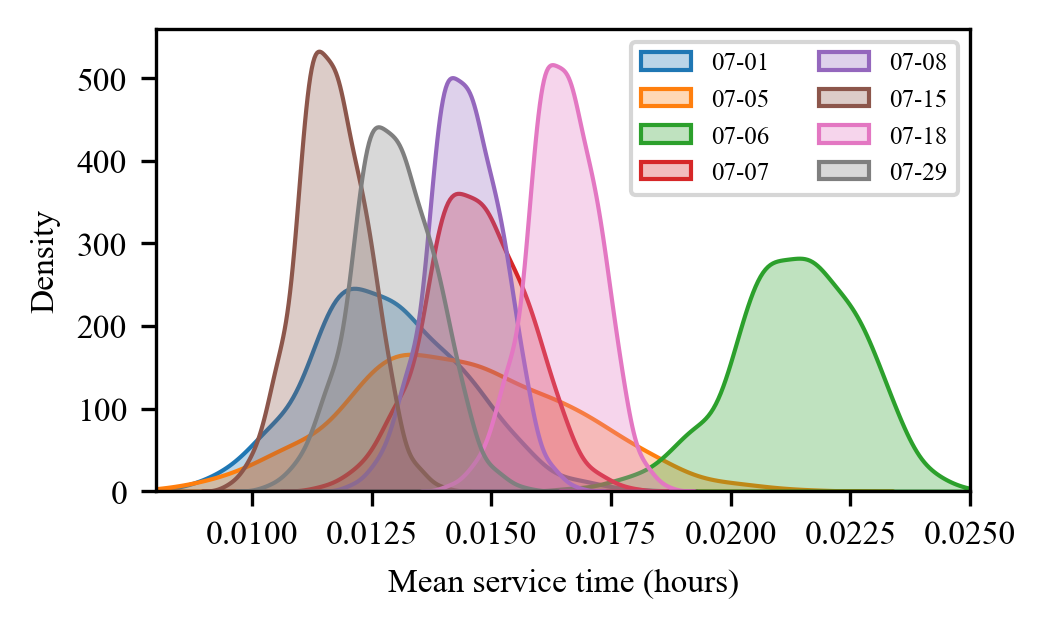

In [42]:
plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(figsize=(3.5,2.0), dpi=300)

# for i in range(start_day,end_day+1):
for i in (1, 5, 6, 7, 8, 15, 18, 29):

    plotting_df = pd.DataFrame(
        {
            "LGA": all_service_time_samples[i-1,:],
            "group": f"{year:04d}-{month:02d}-{i:02d} posterior",
        },
    ) 

    sns.kdeplot(
        x="LGA",
        data=plotting_df,
        ax=ax,
        # hue="group",
        # palette=palette,
        label=f"{month:02d}-{i:02d}",
        alpha=.3,
        fill=True,
    )

ax.legend(
    fontsize=6, 
    # handlelength=.7, 
    # handletextpad=.4,
    ncol=2
)
ax.set_xlim(.008, .025)

ax.set_xlabel("Mean service time (hours)")
ax.set_ylabel("Density")

fig.show()

for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/s_phi_2019-07_selection.{ext}', bbox_inches='tight', pad_inches=0)